Optimization terminated successfully.
         Current function value: 0.681774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675727
         Iterations 5


<Axes: xlabel='timeline'>

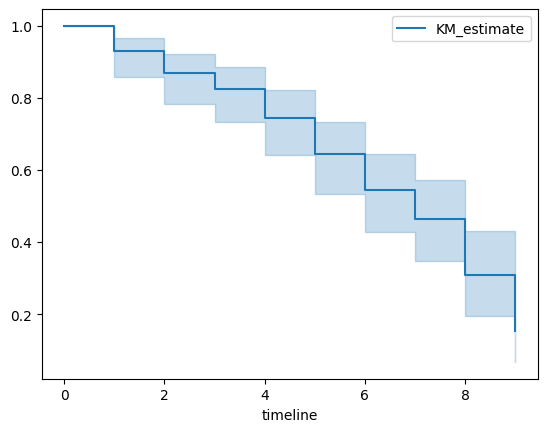

In [2]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from lifelines import KaplanMeierFitter

# 1. Setup - Define directories for saving outputs
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

# 2. Data Preparation - Load Example Data
data_censored = pd.DataFrame({  # Dummy dataset
    'id': np.arange(1, 101),
    'period': np.random.randint(1, 10, 100),
    'treatment': np.random.choice([0, 1], 100),
    'outcome': np.random.choice([0, 1], 100),
    'eligible': np.random.choice([0, 1], 100),
    'age': np.random.randint(30, 70, 100),
    'x1': np.random.randn(100),
    'x2': np.random.randn(100),
    'x3': np.random.randn(100),
    'censored': np.random.choice([0, 1], 100)
})

# 3. Weight Models and Censoring - Logistic Regression for IPCW
X = sm.add_constant(data_censored[['age', 'x1', 'x3']])
Y = data_censored['treatment']
model = sm.Logit(Y, X).fit()
data_censored['switch_weight'] = model.predict(X)

X_censor = sm.add_constant(data_censored[['x2', 'x1']])
Y_censor = 1 - data_censored['censored']
censor_model = sm.Logit(Y_censor, X_censor).fit()
data_censored['censor_weight'] = censor_model.predict(X_censor)

# 4. Calculate Weights - Multiply individual weights
data_censored['final_weight'] = data_censored['switch_weight'] * data_censored['censor_weight']

# 5. Specify Outcome Model (Placeholder)
def fit_outcome_model(data, adjustment_terms=[]):
    X = sm.add_constant(data[adjustment_terms]) if adjustment_terms else sm.add_constant(data['age'])
    Y = data['outcome']
    model = sm.Logit(Y, X).fit()
    return model

outcome_model = fit_outcome_model(data_censored, adjustment_terms=['x2'])

# 6. Expand Trials (Placeholder for Expansion)
def expand_trials(data):
    return data.copy()  # Placeholder for data expansion logic

expanded_data = expand_trials(data_censored)

# 7. Load Sample Data
def load_sample_data(data, seed=1234, p_control=0.5):
    np.random.seed(seed)
    return data.sample(frac=p_control)

sampled_data = load_sample_data(expanded_data)

# 8. Fit Marginal Structural Model
def fit_msm(data):
    X = sm.add_constant(data[['final_weight']])
    Y = data['outcome']
    model = sm.Logit(Y, X).fit()
    return model

msm_model = fit_msm(sampled_data)

# 9. Inference using Kaplan-Meier Survival Estimation
kmf = KaplanMeierFitter()
kmf.fit(durations=data_censored['period'], event_observed=data_censored['outcome'])
kmf.plot_survival_function()
